In [1]:
import os, sys
#current_dir = os.getcwd()
HOME_DIR = '/home/denys/projects/ml-models/kaggle/dog-breed-identification/'
DATA_HOME_DIR = HOME_DIR + 'data/'
#DATA_HOME_DIR = HOME_DIR + '/data/sample/'

In [18]:
from glob import glob
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam

from keras.regularizers import l2

In [20]:
%matplotlib inline

from keras.preprocessing import image
from sklearn.model_selection import KFold

import utils; reload(utils)
from utils import plot_learning_curve
from utils import save_array, load_array, onehot
from utils import get_batches, get_data,  get_breed

In [4]:
labels_df = pd.read_csv("data/labels.csv")

In [5]:
train_data = get_data(DATA_HOME_DIR+'train')

TypeError: get_data() got an unexpected keyword argument 'target_size'

In [10]:
save_array(DATA_HOME_DIR + 'train_244_244.data', train_data)

In [5]:
train_data = load_array(DATA_HOME_DIR+'train_244_244.data')

In [6]:
target_size = (244,244)
batches = get_batches(DATA_HOME_DIR + 'train', shuffle=False, batch_size=1, target_size=target_size)

Found 9225 images belonging to 120 classes.


In [7]:
train_classes = batches.classes
train_labels = onehot(train_classes)
train_filenames = batches.filenames
train_class_indices = batches.class_indices

In [15]:
model_path = DATA_HOME_DIR + "models/"
logs_path = HOME_DIR + "logs/"

In [11]:
kf = KFold(n_splits=3, shuffle=True)
kf.get_n_splits(train_data)

3

In [75]:
from keras.callbacks import CSVLogger
model_name = "vgg16"
date_of_start = "0204_0151"
csv_logger = CSVLogger(logs_path + model_name + date_of_start + '.log', append=True)

In [13]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet

# = {"vgg16": VGG16(weights='imagenet', include_top=False),
         # "resnet50" : ResNet50(weights='imagenet', include_top=False),
          #"InceptionV3": InceptionV3(weights='imagenet', include_top=False),
          #"InceptionResNetV2": InceptionResNetV2(weights='imagenet', include_top=False)}
 #        }

In [44]:
from keras.optimizers import Adam

def get_model(base_model, weights=None):
    x = BatchNormalization()(base_model.output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(200, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(120, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)  
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), metrics=["accuracy"], loss='categorical_crossentropy')
    
    if weights != None:
        model.load_weights(weights)
    
    return model

In [56]:
def get_ResNet50():
    base_model = ResNet50(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    predictions = Dense(120, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.load_weights(model_path + 'resnet50_0130_0121.h5')
    
    return model

In [57]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False)
model = get_model(base_model, model_path + "vgg160203_1625.h5")
model1 = get_model(base_model, model_path + "vgg16_0203_1402.h5")
model2 = get_ResNet50()

In [ ]:
batch_size = 14
iteration = 0
for train_index, valid_index in kf.split(train_data):
    model.optimizer.lr = 0.00001

    train_split, valid_split = train_data[train_index], train_data[valid_index]
    train_labels_split, valid_labels_split = train_labels[train_index], train_labels[valid_index]

    batches = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                                       height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True).flow(train_split, train_labels_split, batch_size=batch_size, shuffle=True)
    val_batches = image.ImageDataGenerator().flow(valid_split, valid_labels_split, batch_size=batch_size, shuffle=False)
    
    
    model.fit_generator(batches, steps_per_epoch=batches.n / batch_size, epochs=10, validation_data=val_batches, 
                        validation_steps=val_batches.n, verbose=1, callbacks=[csv_logger])
            
    model.save_weights(model_path + model_name + date_of_start + iteration +'.h5')
    iteration +=1
    #print model.test_on_batch(valid_split, valid_labels_split)

Epoch 1/10
438/439 [============================>.] - ETA: 0s - loss: 0.8272 - acc: 0.7593

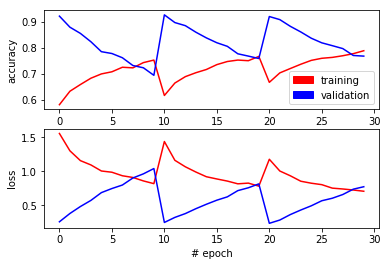

In [21]:
plot_learning_curve(logs_path + "vgg160203_1625.log")

In [63]:
model.outputs[0]

<tf.Tensor 'dense_20/Softmax:0' shape=(?, 120) dtype=float32>

In [64]:
from keras.layers import Average
from keras.layers import Input

models = [model, model1, model2]

def ensemble(models, model_inputs):
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_inputs, y, name='ensemble')
    
    return model

ensemble_model = ensemble(models, [base_model.input, model2.input])

In [47]:
def prepare_predictions(pred_probs):
    prepared_result = []
    max_probs = get_max_prob_per_item(pred_probs)
    for row, max_prob in zip(pred_probs, max_probs):
        prepared_result.append(np.vectorize(lambda prob: prob if prob == max_prob else 0.0)(row))
    return prepared_result

In [73]:
ensemble_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_11[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [69]:
gen = image.ImageDataGenerator()
test_batches = gen.flow_from_directory(DATA_HOME_DIR + "test", target_size=target_size, batch_size=1, shuffle=False)

Found 10357 images belonging to 2 classes.


In [70]:
gen1 = image.ImageDataGenerator()
test_batches1 = gen.flow_from_directory(DATA_HOME_DIR + "test", target_size=target_size, batch_size=1, shuffle=False)

Found 10357 images belonging to 2 classes.


In [72]:
test_batches.reset()
test_batches1.reset()
filenames = test_batches.filenames
test_probs = ensemble_model.predict_generator(test_batches, test_batches1, len(filenames))

ValueError: The model expects 2  arrays, but only received one array. Found: array with shape (1, 244, 244, 3)

In [50]:
len(test_probs)
print np.argmax(test_probs[54])
print test_batches.filenames[54]

112
unknown/012ca7efe684c5cdfb83f35e8fbafe1b.jpg


In [51]:
def get_ids(filenames):
    return np.vectorize(lambda filename: filename[-36:-4])(filenames)

In [52]:
test_ids = get_ids(test_batches.filenames)
len(test_ids)

10357

In [53]:
header = sorted(train_class_indices.keys())
header.insert(0, "id")
header = ','.join(header)

In [54]:
result = np.c_[test_ids, np.clip(test_probs, 0.05, 0.9)]

In [55]:
np.savetxt('vgg_esembled_2models_clip.csv', result, delimiter=',', header=header, comments="", fmt='%s')

In [74]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.